In [1]:
!pip install visualkeras seaborn

In [2]:
import os

DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [4]:
import h5py

In [5]:
tf.keras.backend.clear_session()

In [6]:
train_path = '../data/Coivd-19_Synthetic/GANGEN_2022-6-30-05-53_v5'
test_path = '../data/Covid-19 Image Dataset/test'

In [7]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [8]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

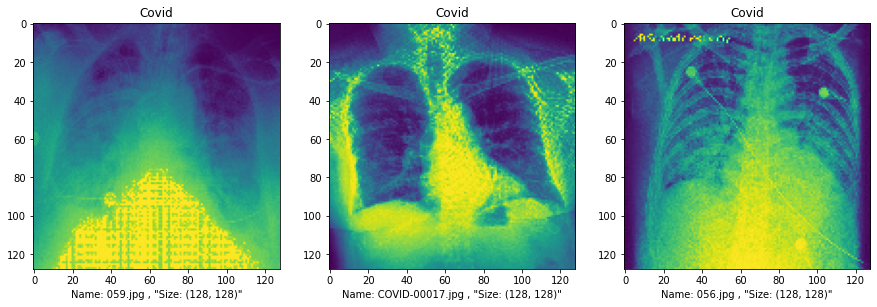

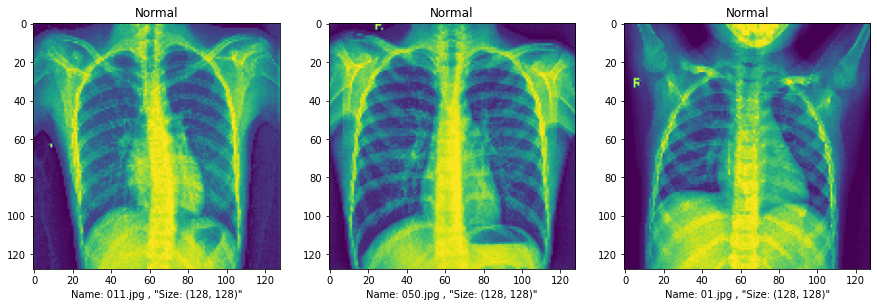

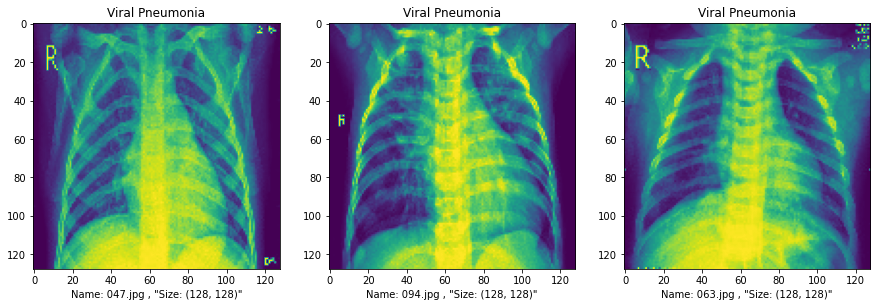

In [9]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [11]:
img_size = 128
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size, img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size, img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [12]:
model = Sequential()
# model.add(Conv2D(filters=16, input_shape=(img_size*img_size*3, ), kernel_size=(9,9), strides=(5,5), padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())

# # Passing it to a dense layer
# model.add(Flatten())
model.add(Flatten(input_shape = (img_size, img_size, 3)))
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.4)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.45)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.2)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(32))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.2)) # 2022年6月30日06点07分 avoid underfitting
model.add(BatchNormalization())
#  output Layer 
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

In [13]:
# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [14]:
!pip install pydot

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0

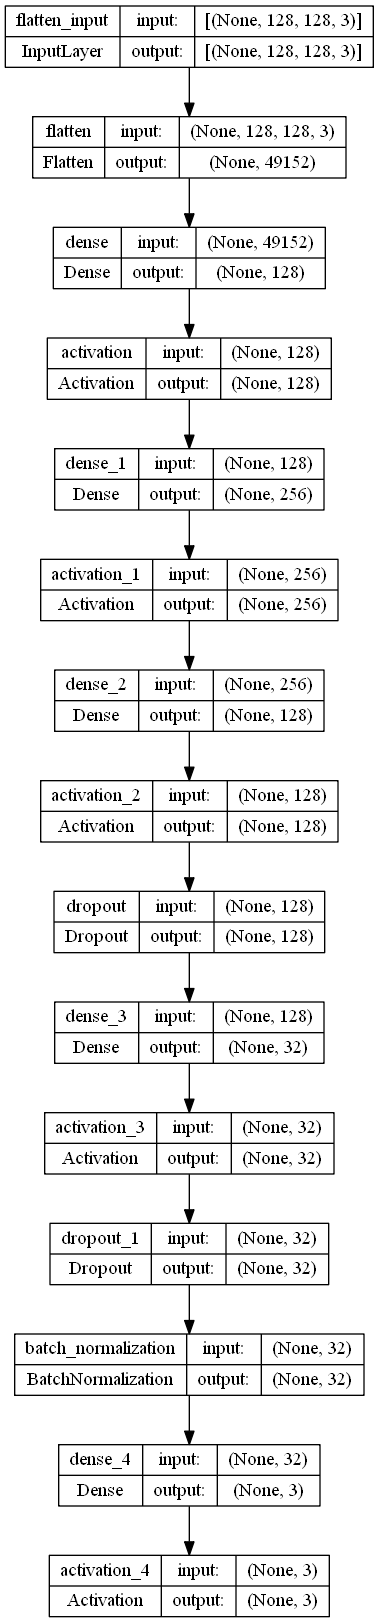

In [16]:
plot_model(model, to_file='../images/mlp_model.png', show_shapes=True, show_layer_names=True)

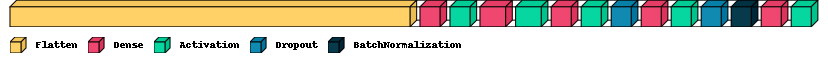

In [17]:
visualkeras.layered_view(model, legend=True)

In [18]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1), 
#              ModelCheckpoint('../models/mlp_model_cacgan.h5', save_best_only=True)]
callbacks = [EarlyStopping(monitor='val_accuracy', patience=100, verbose=1), 
             ModelCheckpoint('../models/mlp_model.h5', save_best_only=True)] # for future training 2022年6月30日06点35分

In [19]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
!pip install h5py

In [21]:
history = model.fit(train_generator,
                    epochs=320,
                    validation_data=test_generator,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/320
16/16 [==============================] - 3s 124ms/step - loss: 1.2864 - accuracy: 0.3705 - val_loss: 1.8012 - val_accuracy: 0.3939
Epoch 2/320
16/16 [==============================] - 2s 118ms/step - loss: 1.1516 - accuracy: 0.4263 - val_loss: 1.1754 - val_accuracy: 0.3939
Epoch 3/320
16/16 [==============================] - 2s 127ms/step - loss: 1.0978 - accuracy: 0.4542 - val_loss: 0.8013 - val_accuracy: 0.5455
Epoch 4/320
16/16 [==============================] - 2s 109ms/step - loss: 1.0614 - accuracy: 0.4861 - val_loss: 0.9660 - val_accuracy: 0.6212
Epoch 5/320
16/16 [==============================] - 2s 109ms/step - loss: 0.9612 - accuracy: 0.5538 - val_loss: 1.2151 - val_accuracy: 0.5606
Epoch 6/320
16/16 [==============================] - 2s 117ms/step - loss: 0.8777 - accuracy: 0.5976 - val_loss: 0.7126 - val_accuracy: 0.5909
Epoch 7/320
16/16 [==============================] - 2s 129ms/step - loss: 0.9486 - accuracy: 0.5657 - val_loss: 0.7107 - val_accuracy: 0.6364

Epoch 58/320
16/16 [==============================] - 2s 108ms/step - loss: 0.5290 - accuracy: 0.7729 - val_loss: 0.8221 - val_accuracy: 0.5303
Epoch 59/320
16/16 [==============================] - 2s 110ms/step - loss: 0.5783 - accuracy: 0.7410 - val_loss: 0.7483 - val_accuracy: 0.5758
Epoch 60/320
16/16 [==============================] - 2s 109ms/step - loss: 0.5448 - accuracy: 0.7291 - val_loss: 0.7567 - val_accuracy: 0.5909
Epoch 61/320
16/16 [==============================] - 2s 108ms/step - loss: 0.5739 - accuracy: 0.7570 - val_loss: 0.7772 - val_accuracy: 0.6061
Epoch 62/320
16/16 [==============================] - 2s 107ms/step - loss: 0.5447 - accuracy: 0.7849 - val_loss: 0.6984 - val_accuracy: 0.6818
Epoch 63/320
16/16 [==============================] - 2s 110ms/step - loss: 0.5767 - accuracy: 0.7570 - val_loss: 0.8330 - val_accuracy: 0.5606
Epoch 64/320
16/16 [==============================] - 2s 107ms/step - loss: 0.5422 - accuracy: 0.7610 - val_loss: 0.8157 - val_accuracy:

Epoch 115/320
16/16 [==============================] - 2s 110ms/step - loss: 0.4520 - accuracy: 0.8367 - val_loss: 0.8711 - val_accuracy: 0.5606
Epoch 116/320
16/16 [==============================] - 2s 108ms/step - loss: 0.4951 - accuracy: 0.7928 - val_loss: 0.6801 - val_accuracy: 0.6515
Epoch 117/320
16/16 [==============================] - 2s 110ms/step - loss: 0.5035 - accuracy: 0.8008 - val_loss: 0.7764 - val_accuracy: 0.6212
Epoch 118/320
16/16 [==============================] - 2s 109ms/step - loss: 0.6045 - accuracy: 0.7769 - val_loss: 0.7317 - val_accuracy: 0.6667
Epoch 119/320
16/16 [==============================] - 2s 111ms/step - loss: 0.4649 - accuracy: 0.8327 - val_loss: 0.9087 - val_accuracy: 0.5455
Epoch 120/320
16/16 [==============================] - 2s 111ms/step - loss: 0.4733 - accuracy: 0.8406 - val_loss: 0.7654 - val_accuracy: 0.6667
Epoch 121/320
16/16 [==============================] - 2s 109ms/step - loss: 0.4162 - accuracy: 0.8486 - val_loss: 0.7914 - val_ac

16/16 [==============================] - 2s 112ms/step - loss: 0.4715 - accuracy: 0.8247 - val_loss: 0.6239 - val_accuracy: 0.6970
Epoch 172/320
16/16 [==============================] - 2s 101ms/step - loss: 0.4281 - accuracy: 0.8406 - val_loss: 0.8872 - val_accuracy: 0.6061
Epoch 173/320
16/16 [==============================] - 2s 102ms/step - loss: 0.4613 - accuracy: 0.8247 - val_loss: 0.8059 - val_accuracy: 0.5909
Epoch 174/320
16/16 [==============================] - 2s 103ms/step - loss: 0.5132 - accuracy: 0.8207 - val_loss: 0.7685 - val_accuracy: 0.5758
Epoch 175/320
16/16 [==============================] - 2s 99ms/step - loss: 0.4563 - accuracy: 0.8247 - val_loss: 0.6339 - val_accuracy: 0.7121
Epoch 176/320
16/16 [==============================] - 2s 99ms/step - loss: 0.4231 - accuracy: 0.8247 - val_loss: 0.6961 - val_accuracy: 0.6515
Epoch 177/320
16/16 [==============================] - 2s 102ms/step - loss: 0.4607 - accuracy: 0.8327 - val_loss: 0.6324 - val_accuracy: 0.6970
E

Epoch 228/320
16/16 [==============================] - 2s 99ms/step - loss: 0.4341 - accuracy: 0.8606 - val_loss: 0.6794 - val_accuracy: 0.7273
Epoch 229/320
16/16 [==============================] - 2s 97ms/step - loss: 0.4328 - accuracy: 0.8008 - val_loss: 0.7108 - val_accuracy: 0.6970
Epoch 230/320
16/16 [==============================] - 2s 100ms/step - loss: 0.3764 - accuracy: 0.8566 - val_loss: 0.9046 - val_accuracy: 0.5606
Epoch 231/320
16/16 [==============================] - 2s 100ms/step - loss: 0.4117 - accuracy: 0.8167 - val_loss: 0.7145 - val_accuracy: 0.6818
Epoch 232/320
16/16 [==============================] - 2s 101ms/step - loss: 0.4131 - accuracy: 0.8486 - val_loss: 0.6670 - val_accuracy: 0.7424
Epoch 233/320
16/16 [==============================] - 2s 100ms/step - loss: 0.4259 - accuracy: 0.8526 - val_loss: 0.9907 - val_accuracy: 0.5909
Epoch 234/320
16/16 [==============================] - 2s 98ms/step - loss: 0.4411 - accuracy: 0.8287 - val_loss: 0.7083 - val_accur

Epoch 285/320
16/16 [==============================] - 2s 99ms/step - loss: 0.6143 - accuracy: 0.7530 - val_loss: 1.7492 - val_accuracy: 0.5152
Epoch 286/320
16/16 [==============================] - 2s 99ms/step - loss: 0.5907 - accuracy: 0.7331 - val_loss: 0.7294 - val_accuracy: 0.6364
Epoch 287/320
16/16 [==============================] - 2s 98ms/step - loss: 0.4482 - accuracy: 0.8526 - val_loss: 0.6765 - val_accuracy: 0.6667
Epoch 288/320
16/16 [==============================] - 2s 97ms/step - loss: 0.3935 - accuracy: 0.8486 - val_loss: 0.7420 - val_accuracy: 0.6970
Epoch 289/320
16/16 [==============================] - 2s 98ms/step - loss: 0.3595 - accuracy: 0.8446 - val_loss: 0.5655 - val_accuracy: 0.7879
Epoch 290/320
16/16 [==============================] - 2s 99ms/step - loss: 0.5121 - accuracy: 0.8367 - val_loss: 0.9093 - val_accuracy: 0.5909
Epoch 291/320
16/16 [==============================] - 2s 98ms/step - loss: 0.4810 - accuracy: 0.8008 - val_loss: 1.2083 - val_accuracy:

In [22]:
model = load_model('../models/mlp_model.h5')

In [23]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

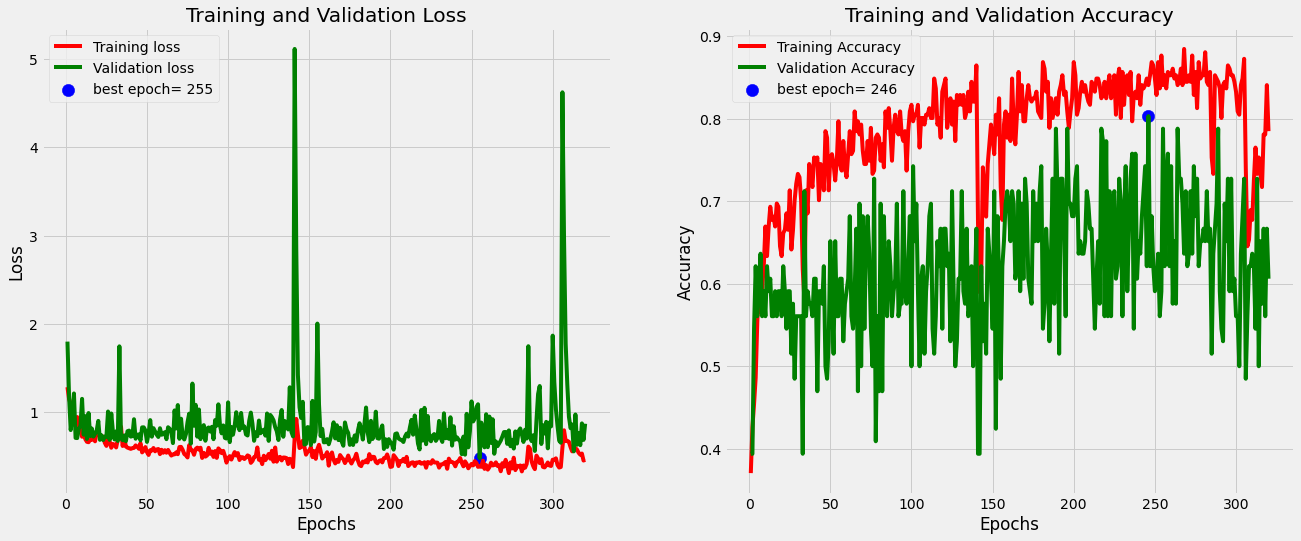

In [24]:
tr_plot(history, 0)

In [25]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 1s 14ms/step - loss: 0.4851 - accuracy: 0.7879
Loss: 48.511
Accuracy: 78.788


In [26]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

66/66 [==============================] - 1s 13ms/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1,
        2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [27]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [28]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('../images/con_mat_cacgan.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [29]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [30]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[24  0  1]
 [ 2 12  3]
 [ 0  8 16]]


F1 Score: 0.7880452158527025


                 precision    recall  f1-score   support

          Covid       0.92      0.96      0.94        25
         Normal       0.60      0.71      0.65        17
Viral Pneumonia       0.80      0.67      0.73        24

       accuracy                           0.79        66
      macro avg       0.77      0.78      0.77        66
   weighted avg       0.80      0.79      0.79        66



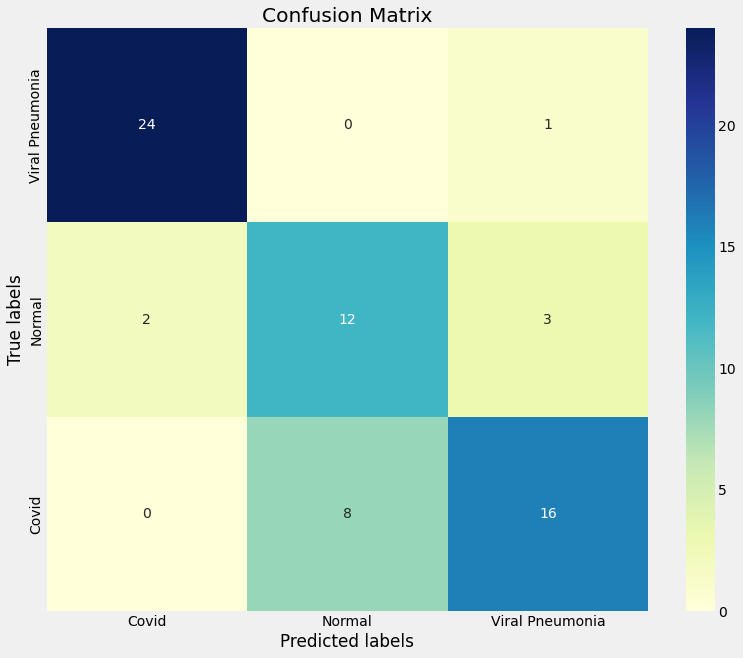

In [31]:
cal_score(model, plot=True)